# **MBTI Classification Modeling**
**고갑승, 박혜원, 안대현, 이지은, 최규수**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Import Modules & Load Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import scipy as sp
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.stem import PorterStemmer

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import TruncatedSVD

In [0]:
dir = '/content/drive/My Drive/Colab Notebooks/'

In [0]:
data = pd.read_csv(dir+'mbti_1.csv')

In [5]:
data.head() # type과 그 분석을 위한 post로 구성, |||로 구분

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
data.info() #결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
type     8675 non-null object
posts    8675 non-null object
dtypes: object(2)
memory usage: 135.7+ KB


## EDA

In [0]:
from pprint import pprint

# from Bokeh Accent[5] colors
color_codes = ["#8797b8", "#ffd6c0", '#fdc086', '#ffff99', '#386cb0']
colors = sns.color_palette(color_codes)

sns.set_palette(colors)

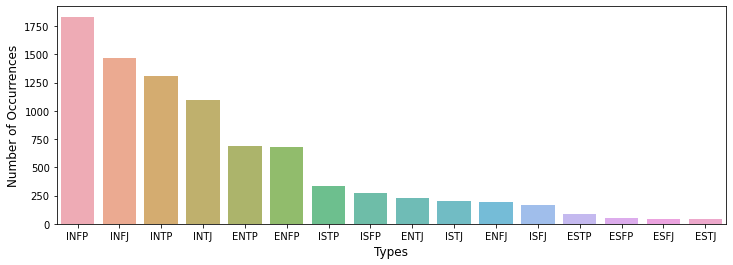

In [9]:
cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

### Split the MBTI type

In [0]:
data['EI'] =  data['type'].astype(str).str[0]
data['NS'] =  data['type'].astype(str).str[1]
data['FT'] =  data['type'].astype(str).str[2]
data['JP'] =  data['type'].astype(str).str[3]

In [11]:
dum = pd.get_dummies(data.loc[:, "EI":"JP"], drop_first = True)
data = pd.concat([data, dum], axis = 1)
data.head()

,type,posts,EI,NS,FT,JP,EI_I,NS_S,FT_T,JP_P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,1,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,0,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,1,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,1,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,0,0,1,0


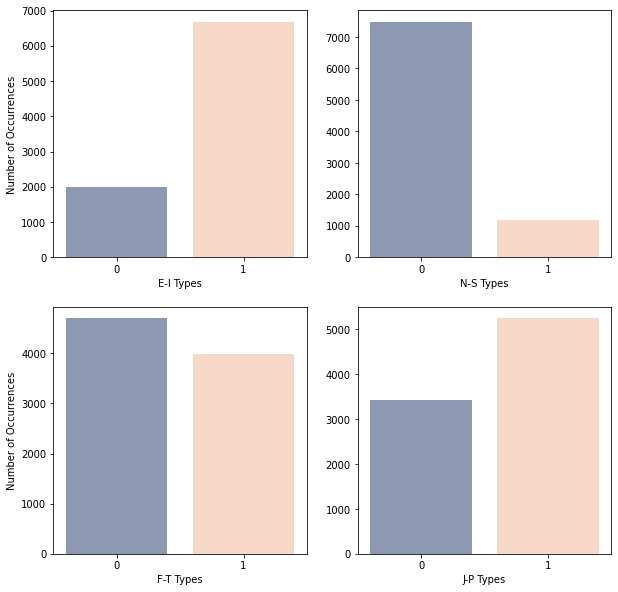

In [12]:
cnt_IE = data['EI_I'].value_counts()
cnt_NS = data['NS_S'].value_counts()
cnt_TF = data['FT_T'].value_counts()
cnt_JP = data['JP_P'].value_counts()

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.barplot(cnt_IE.index, cnt_IE.values)
plt.ylabel('Number of Occurrences')
plt.xlabel('E-I Types')

plt.subplot(2, 2, 2)
sns.barplot(cnt_NS.index, cnt_NS.values)
plt.xlabel('N-S Types')

plt.subplot(2, 2, 3)
sns.barplot(cnt_TF.index, cnt_TF.values)
plt.ylabel('Number of Occurrences')
plt.xlabel('F-T Types')

plt.subplot(2, 2, 4)
sns.barplot(cnt_JP.index, cnt_JP.values)
plt.xlabel('J-P Types')

plt.show()

### Number of Posts

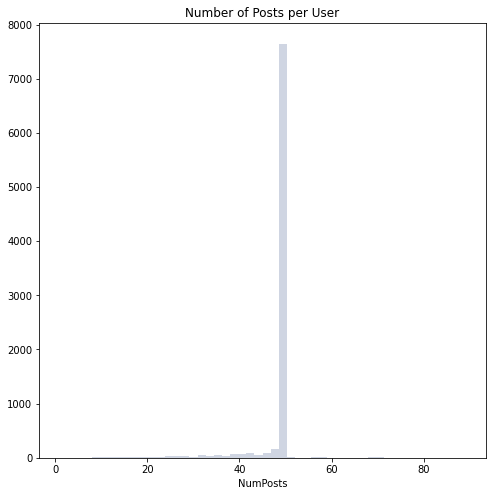

In [14]:
data['NumPosts'] = data['posts'].apply(lambda x: len(x.split('|||')))
plt.figure(figsize = (8, 8))
sns.distplot(data["NumPosts"], kde=False).set_title("Number of Posts per User")
plt.show()

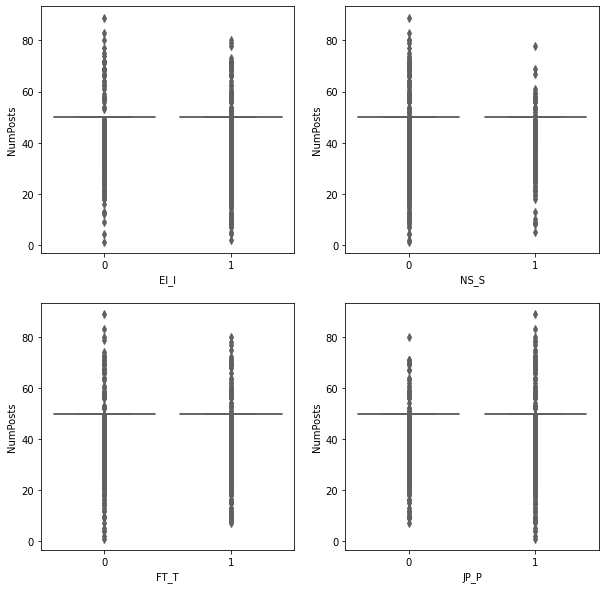

In [15]:
plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
sns.boxplot("EI_I", "NumPosts",data = data)
plt.subplot(2, 2, 2)
sns.boxplot("NS_S", "NumPosts",data = data)
plt.subplot(2, 2, 3)
sns.boxplot("FT_T", "NumPosts",data = data)
plt.subplot(2, 2, 4)
sns.boxplot("JP_P", "NumPosts",data = data)

plt.show() 

### Lengths of all posts

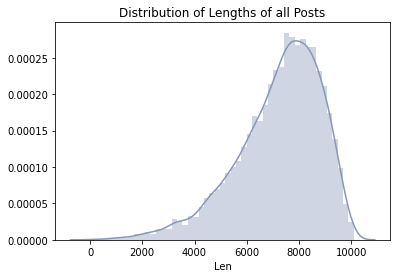

In [16]:
data['Len'] = data['posts'].apply(len)
sns.distplot(data['Len']).set_title("Distribution of Lengths of all Posts")
plt.show()

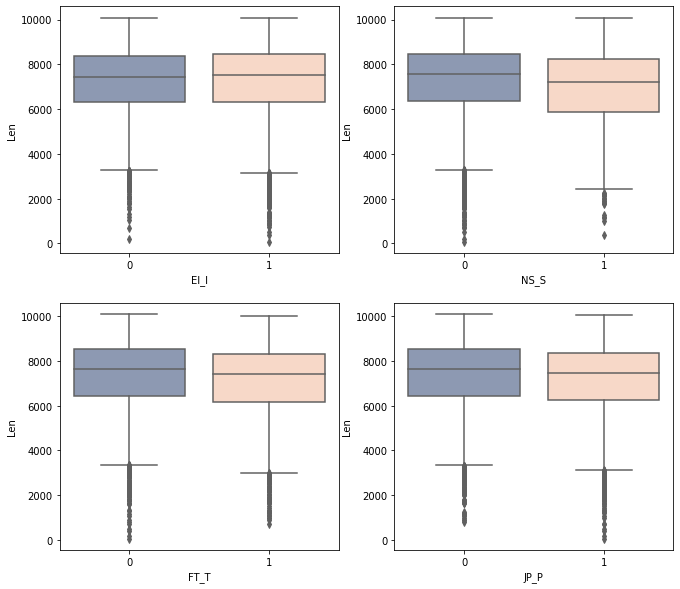

In [17]:
plt.figure(figsize = (11, 10))

plt.subplot(2, 2, 1)
sns.boxplot("EI_I", "Len",data = data)
plt.subplot(2, 2, 2)
sns.boxplot("NS_S", "Len",data = data)
plt.subplot(2, 2, 3)
sns.boxplot("FT_T", "Len",data = data)
plt.subplot(2, 2, 4)
sns.boxplot("JP_P", "Len",data = data)

plt.show() 

### Words per Comment

In [18]:
data['words_per_comment'] = data['posts'].apply(lambda x: len(x.split())/(x.count('|||')+1))  # 아이디당 수집한 댓글의 개수(|||+1)로 나눠줌
data.head()

,type,posts,EI,NS,FT,JP,EI_I,NS_S,FT_T,JP_P,NumPosts,Len,words_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,1,0,0,0,50,4652,11.12
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,0,0,1,1,50,7053,23.40
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,1,0,1,1,50,5265,16.72
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,1,0,1,0,50,6271,21.28
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,0,0,1,0,50,6111,19.34


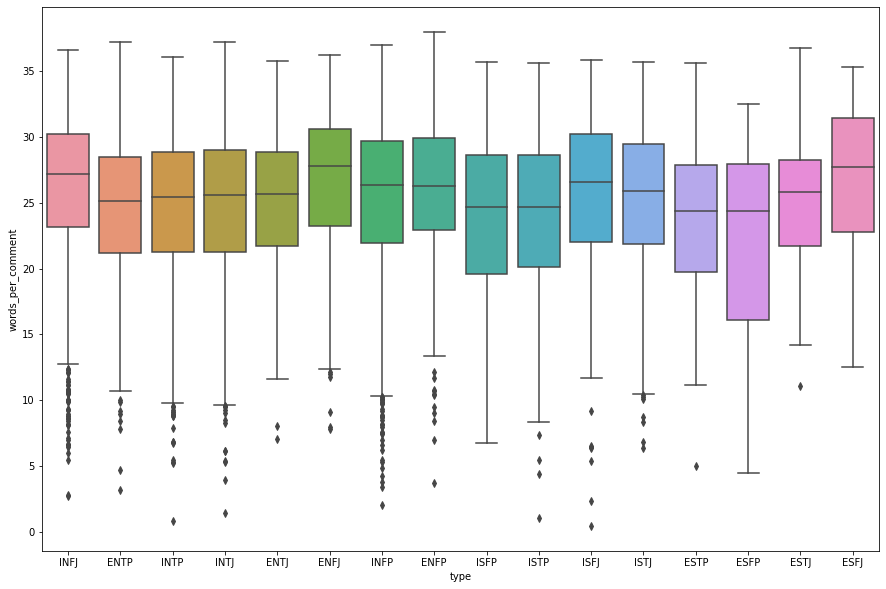

In [19]:
plt.figure(figsize=(15,10))
sns.boxplot("type", "words_per_comment", data=data)
plt.show() 

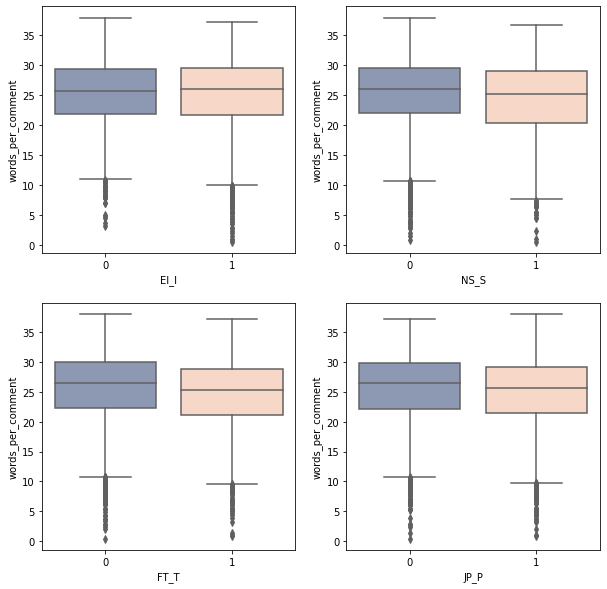

In [20]:
plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
sns.boxplot("EI_I", "words_per_comment",data = data)
plt.subplot(2, 2, 2)
sns.boxplot("NS_S", "words_per_comment",data = data)
plt.subplot(2, 2, 3)
sns.boxplot("FT_T", "words_per_comment",data = data)
plt.subplot(2, 2, 4)
sns.boxplot("JP_P", "words_per_comment",data = data)

plt.show() 

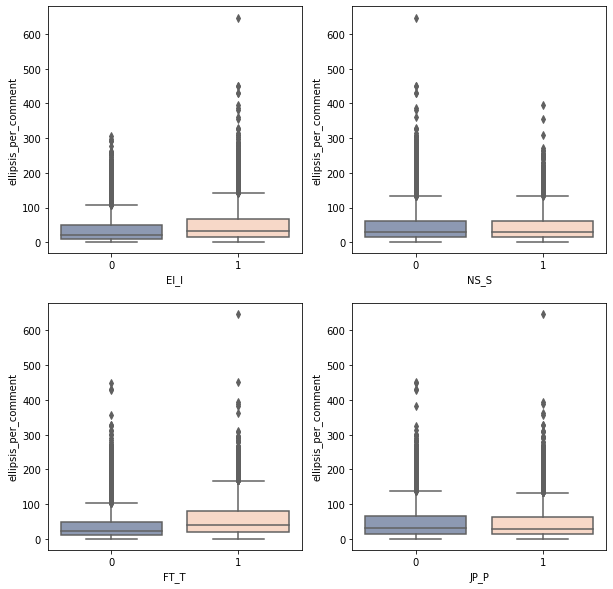

In [21]:
data['ellipsis_per_comment'] = data['posts'].apply(lambda x: x.count('.')/(x.count('!')+1))

plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
sns.boxplot("EI_I", "ellipsis_per_comment",data = data)
plt.subplot(2, 2, 2)
sns.boxplot("NS_S", "ellipsis_per_comment",data = data)
plt.subplot(2, 2, 3)
sns.boxplot("FT_T", "ellipsis_per_comment",data = data)
plt.subplot(2, 2, 4)
sns.boxplot("JP_P", "ellipsis_per_comment",data = data)

plt.show() 

타입별로 유의미한 차이를 보는 수치형 변수 없음.

## Text Cleaning

### Stop words

In [0]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text) 
    return text

In [25]:
data['clean_posts'] = data['posts'].apply(cleanText)
data.clean_posts.head()

0    '<URL> <URL> enfp and intj moments  <URL>  spo...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   <URL> Of course, to which I...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired. That's another silly misconcept...
Name: clean_posts, dtype: object

In [0]:
def preprocess_text(df, remove_special=True):
    #Keep EOS
    #[., ?, !]를 단어로 바꿔줌
    df["clean_posts"] = df["clean_posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["clean_posts"] = df["clean_posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["clean_posts"] = df["clean_posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    #영어, 숫자, _, 공백도 아닌 것들을 없애줌
    df["clean_posts"] = df["clean_posts"].apply(lambda x: re.sub(r'[^\w\s]','',x)) 

    #Remove Non-words
    #알파벳, 공백 아닌 것들 없애줌
    df["clean_posts"] = df["clean_posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x)) 

    #To lower
    #단어들 모두 소문자로
    df["clean_posts"] = df["clean_posts"].apply(lambda x: x.lower())

    #Remove multiple letter repating words
    #똑같은 알파벳 3번이상 반복되는 애들 없애줌
    df["clean_posts"] = df["clean_posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove short/long words
    #너무 긴단어 제거
    df["clean_posts"] = df["clean_posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove Personality Types Words
    #This is crutial in order to get valid model accuracy estimation for unseen data. 
    #type 단어 'PTypeToken'으로 대체
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    df["clean_posts"] = df["clean_posts"].apply(lambda x: p.sub(' ptypetoken ',x))
    return df

In [27]:
preprocess_text(data,remove_special=True)

,type,posts,EI,NS,FT,JP,EI_I,NS_S,FT_T,JP_P,NumPosts,Len,words_per_comment,ellipsis_per_comment,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,1,0,0,0,50,4652,11.12,33.750000,url url ptypetoken and ptypetoken moments ...
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,0,0,1,1,50,7053,23.40,188.000000,im finding the lack of me in these posts very ...
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,1,0,1,1,50,5265,16.72,19.600000,good one url of course to which i say i kn...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,1,0,1,0,50,6271,21.28,39.500000,dear ptypetoken i enjoyed our conversation...
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,0,0,1,0,50,6111,19.34,75.500000,youre fired eostokendot thats another silly m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,I,S,F,P,1,1,0,1,50,5011,15.92,11.285714,url ixfp just because i always think of cats a...
8671,ENFP,'So...if this thread already exists someplace ...,E,N,F,P,0,0,0,1,50,7902,26.18,5.764706,so eostokendot eostokendot eostokendot if th...
8672,INTP,'So many questions when i do these things. I ...,I,N,T,P,1,0,1,1,50,5772,18.96,76.500000,so many questions when i do these things eosto...
8673,INFP,'I am very conflicted right now when it comes ...,I,N,F,P,1,0,0,1,50,9479,34.10,52.750000,i am very conflicted right now when it comes t...


In [0]:
# word 빈도 살펴보면서 불용어로 처리해야 되는 추가 단어 발생했을 때 쓸 코드

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
mystop = stopwords + ["eostokendot", "ptypetoken", "eostokenexs", "im", "ive", "url"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
## mystop으로 불용어 처리

data['clean_posts'] = data['clean_posts'].apply(lambda x: ' '.join([word for word in x.split() if word not in (mystop)]))

In [0]:
data['clean_posts']

0       moments sportscenter top ten plays pranks life...
1       finding lack posts alarming sex boring positio...
2       good one course say know thats blessing curse ...
3       dear enjoyed conversation day esoteric gabbing...
4       youre fired thats another silly misconception ...
                              ...                        
8670    ixfp always think cats fi doms reason especial...
8671    thread already exists someplace else heck dele...
8672    many questions things would take purple pill p...
8673    conflicted right comes wanting children honest...
8674    long since personalitycafe although doesnt see...
Name: clean_posts, Length: 8675, dtype: object

In [0]:
ps = PorterStemmer()

data['clean_posts'] = data['clean_posts'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [0]:
data['clean_posts'][0]

'moment sportscent top ten play prank lifechang experi life eostokenquest repeat today may perc experi immers last thing friend post facebook commit suicid next day rest peac hello sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth welcom stuff game set match prozac wellbrutin least thirti minut move leg dont mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item youv determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear favorit video game grow current favorit video game eostokenquest cool appear late sad there someon everyon wait thought confid good thing cherish time solitud bc revel within inner world wherea time id workin enjoy time dont worri peopl alway around yo ladi your complimentari personalitywel hey main social outlet xbox live convers even verbal fa

### WordCloud

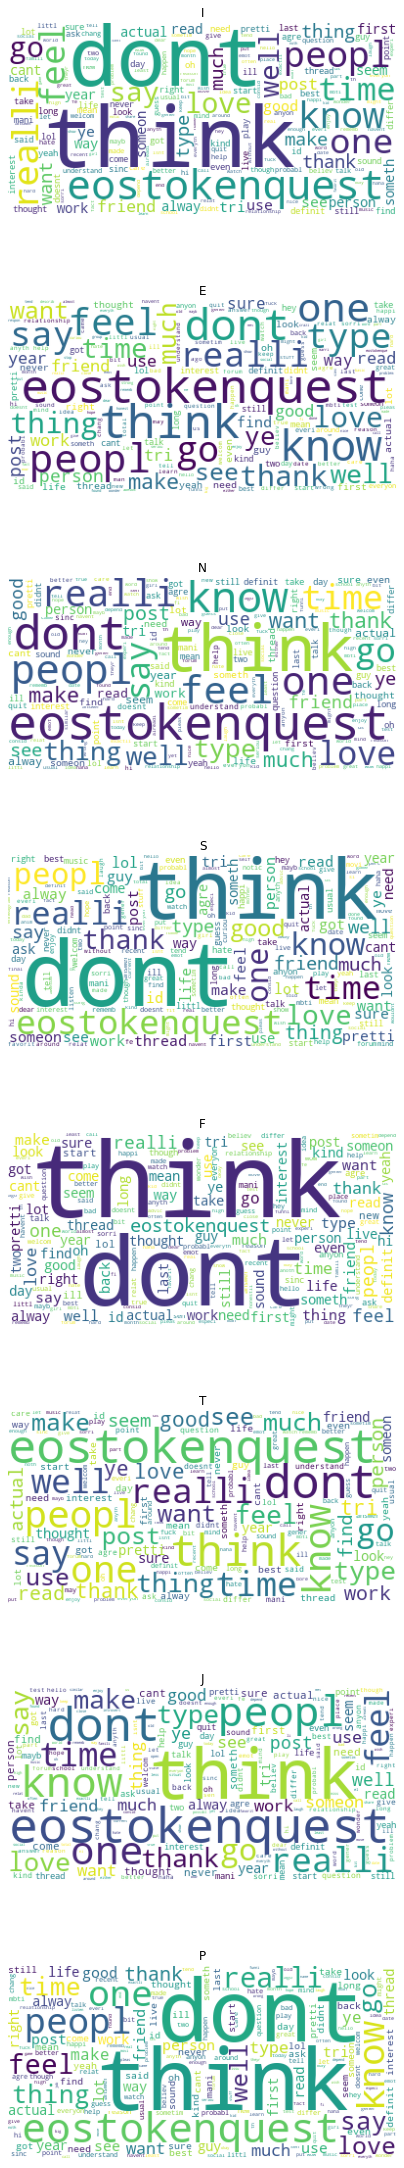

In [0]:
# E, I, N, S, T, F, J, P 에 대한 각각의 워드클라우드
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(8, sharex=True, figsize=(7,5*8))

k = 0

for j in ['EI','NS','FT','JP']:
  for i in data[j].unique():
    data_4 = data[data[j] == i]
    wordcloud = WordCloud(collocations = False, background_color = "white").generate(data_4['clean_posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1


### TF-IDF

In [0]:
t = TfidfVectorizer()
features = t.fit_transform(data['clean_posts']).toarray()
X_all = pd.DataFrame(features)
X_all.shape

In [0]:
c = CountVectorizer()
features = c.fit_transform(data['clean_posts']).toarray()
X_cnt = pd.DataFrame(features)

In [0]:
cnt_sum = X_cnt.sum(axis = 0).value_counts().sort_index()
cnt_sum = pd.concat([cnt_sum, np.cumsum(cnt_sum)], axis = 1)
cnt_sum['NofFeatures'] = X_all.shape[1] - cnt_sum.iloc[:,1]

In [0]:
cnt_sum.columns = ["Count", "CumSum", "NofFeatures"]
#cnt_sum.head()

In [0]:
def tfidf_max(freq):
  t = TfidfVectorizer(max_features=cnt_sum.loc[freq, "NofFeatures"])
  features = t.fit_transform(data['clean_posts']).toarray()
  X = pd.DataFrame(features)
  return X

In [0]:
#X_over1 = tfidf_max(1)
#X_over2 = tfidf_max(2)
#X_over5 = tfidf_max(5)
X_over10 = tfidf_max(10)
X_over50 = tfidf_max(50)
X_over100 = tfidf_max(100) # 3168
X_over299 = tfidf_max(299) # 1625

In [0]:
def tsvd(dim):
  ts = TruncatedSVD(n_components=dim)
  features = ts.fit_transform(X_all)
  X = pd.DataFrame(features)
  return X

In [0]:
# 주의 : 5분 정도 걸림 
X_svd10 = tsvd(10)
X_svd50 = tsvd(50)
X_svd100 = tsvd(100)
X_svd300 = tsvd(300)

In [0]:
X_svd50 = tsvd(50)

## Modeling

### Train-test split

In [0]:
X = data['posts'] # index만 뽑아줄 것, 실제 학습에 사용 X
y = data['type'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state= 42)

In [0]:
y_train = np.array(data.loc[y_train.index, ['EI_I', "NS_S", "FT_T", "JP_P"]])
y_test = np.array(data.loc[y_test.index, ['EI_I', "NS_S", "FT_T", "JP_P"]])

y_train

array([[1, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [1, 0, 1, 1],
       [0, 1, 0, 0]], dtype=uint8)

In [0]:
train_id = X_train.index
test_id = X_test.index

def my_ttsplit(X):
  
  global train_id, test_id

  X_train = np.array(X.iloc[train_id, :])
  X_test = np.array(X.iloc[test_id, :])
  return X_train, X_test

### Modeling

In [0]:
# 모델 선언
lr = LogisticRegression(class_weight='balanced')
lgbm = LGBMClassifier(class_weight='balanced')
xgb = XGBClassifier(n_estimators=100, random_state=42)
nb = GaussianNB()

In [0]:

name=['EI','NS','FT','JP']
model=[lr,xgb,lgbm,nb]

def my_model(Xtrain, Xtest,model_name):
  global y_train, y_test
  global name

  multi_classifier = MultiOutputClassifier(model_name, n_jobs=-1)
  multi_classifier.fit(Xtrain, y_train)
  preds = multi_classifier.predict(Xtest)
  results=pd.DataFrame()

  for i in range(4):
    result = pd.DataFrame([{"test_acc" : accuracy_score(np.array(y_test)[:,i], preds[:,i]),
                          "test_f1" : f1_score(np.array(y_test)[:,i], preds[:,i], average='weighted') }],index=[name[i]])
    
    results=pd.concat([results,result],axis=0)

  return results

In [0]:
data_dic = {"over10" : X_over10, "over50" : X_over50,"over100" : X_over100, "over299" : X_over299}
# data_dic = {"svd10" : X_svd10, "svd50" : X_svd50, "svd100" : X_svd100, "svd300" : X_svd300}

In [0]:
data_list = ["over10", "over50", "over100", "over299"]
# data_list = ["svd10", "svd50", "svd100", "svd300"]

In [0]:
model_result = pd.DataFrame()

for i in data_list:
  print("Data", i, "Start!")
  X_train2, X_test2 = my_ttsplit(data_dic[i])

  name = [n + "_" + i for n in name]

  result = my_model(X_train2, X_test2, nb)
  model_result = pd.concat([model_result, result], axis = 0)
  name=['EI','NS','FT','JP']
  print("Data", i, "End!")

Data over10 Start!
Data over10 End!
Data over50 Start!
Data over50 End!
Data over100 Start!
Data over100 End!
Data over299 Start!
Data over299 End!


In [0]:
model_result

,test_acc,test_f1
EI_over10,0.595083,0.621508
NS_over10,0.727622,0.750691
FT_over10,0.601998,0.601959
JP_over10,0.528621,0.533585
EI_over50,0.657703,0.669830
NS_over50,0.707261,0.741027
FT_over50,0.649635,0.650197
JP_over50,0.561275,0.565740
EI_over100,0.656166,0.672163
NS_over100,0.705724,0.738024


In [0]:
model_result.to_csv(dir+"over_lgbm.csv")

In [0]:
model_result['type'] = [s.split("_")[0] for s in  model_result.index.values]
model_result['data'] = [s.split("_")[1] for s in  model_result.index.values]
model_result.head()

,cv_acc,cv_acc_err,cv_f1,cv_f1_err,cv_loss,cv_loss_err,test_acc,test_f1,type,data
EI_svd10,0.649370,0.022493,0.662572,0.017254,-0.616708,0.014251,0.651556,0.666597,EI,svd10
NS_svd10,0.773224,0.013609,0.777369,0.012178,-0.506067,0.011111,0.761429,0.769353,NS,svd10
FT_svd10,0.696470,0.021790,0.696565,0.021496,-0.591301,0.022174,0.694583,0.694593,FT,svd10
JP_svd10,0.561595,0.013131,0.562832,0.011949,-0.703149,0.006699,0.565886,0.567225,JP,svd10
EI_svd50,0.714423,0.018962,0.706139,0.017012,-0.558095,0.016956,0.711871,0.710675,EI,svd50


## Result

In [0]:
def my_plot(result_data):
  model_result = pd.read_csv(dir + result_data+ ".csv")
  model_result.head()

  model_result['type'] = [s.split("_")[0] for s in  model_result['Unnamed: 0']]
  model_result['data'] = [s.split("_")[1] for s in  model_result['Unnamed: 0']]
  model_result.head()

  plt.figure(figsize = (15, 6))

  plt.suptitle(result_data.upper(), fontsize = 15)
  plt.subplot(1, 2, 1)
  plt.plot(model_result[model_result['type'] == "EI"].data, model_result[model_result['type'] == "EI"].test_acc,
          marker = "o", color = "#D5573B", linewidth = 3, label = "E/I", alpha = 0.7)
  plt.plot(model_result[model_result['type'] == "NS"].data, model_result[model_result['type'] == "NS"].test_acc,
          marker = "s", color = "#ADA0A6", linewidth = 3, label = "N/S")
  plt.plot(model_result[model_result['type'] == "FT"].data, model_result[model_result['type'] == "FT"].test_acc,
          marker = "*", color = "#7C92DB", linewidth = 3, label = "F/T")
  plt.plot(model_result[model_result['type'] == "JP"].data, model_result[model_result['type'] == "JP"].test_acc,
          marker = "+", color = "#8797B8", linewidth = 3, label = "J/P")
  plt.title("Test Accuracy")

  plt.subplot(1,2 , 2)
  plt.plot(model_result[model_result['type'] == "EI"].data, model_result[model_result['type'] == "EI"].test_f1,
          marker = "o", color = "#D5573B", linewidth = 3, label = "E/I", alpha = 0.7)
  plt.plot(model_result[model_result['type'] == "NS"].data, model_result[model_result['type'] == "NS"].test_f1,
          marker = "s", color = "#ADA0A6", linewidth = 3, label = "N/S")
  plt.plot(model_result[model_result['type'] == "FT"].data, model_result[model_result['type'] == "FT"].test_f1,
          marker = "*", color = "#7C92DB", linewidth = 3, label = "F/T")
  plt.plot(model_result[model_result['type'] == "JP"].data, model_result[model_result['type'] == "JP"].test_f1,
          marker = "+", color = "#8797B8", linewidth = 3, label = "J/P")
  plt.title("Test F1 score")

  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.show()

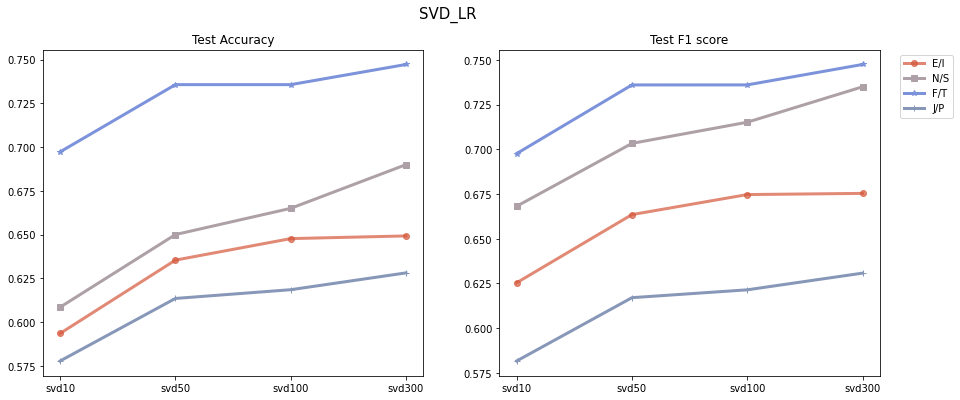

In [0]:
my_plot("svd_lr")

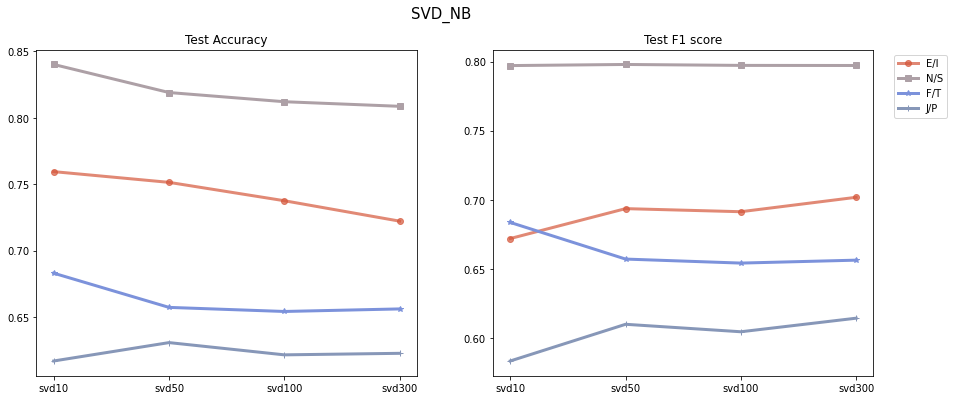

In [0]:
my_plot("svd_nb")

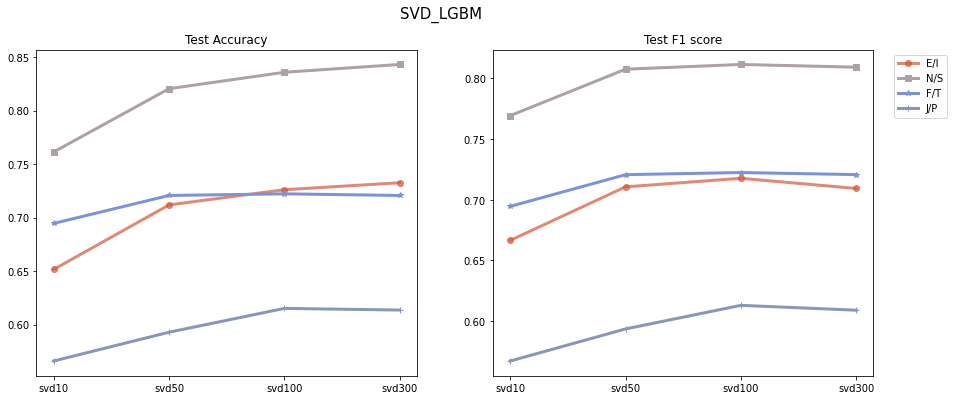

In [0]:
my_plot("svd_lgbm")

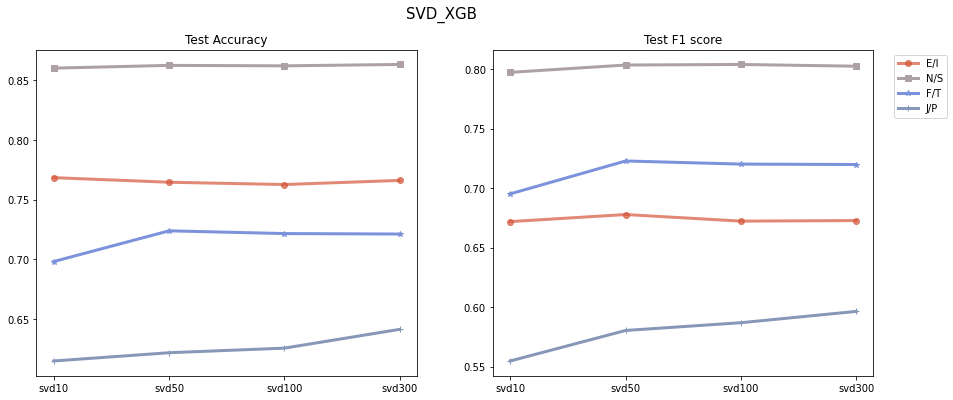

In [0]:
my_plot("svd_xgb")

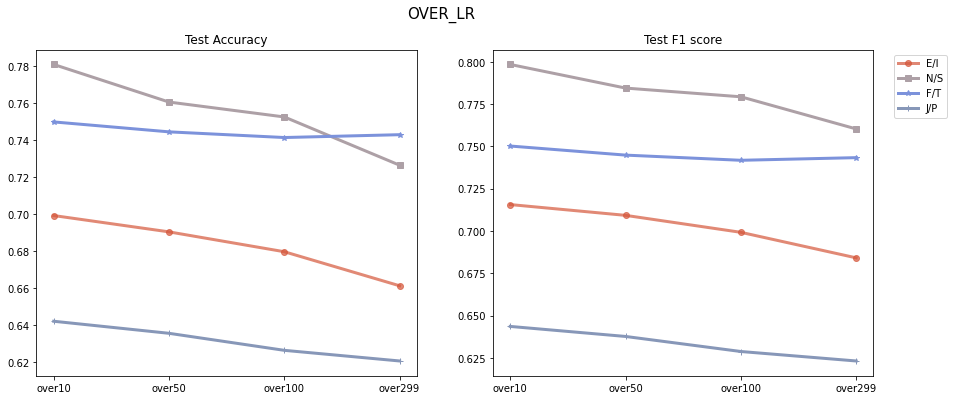

In [0]:
my_plot("over_lr")

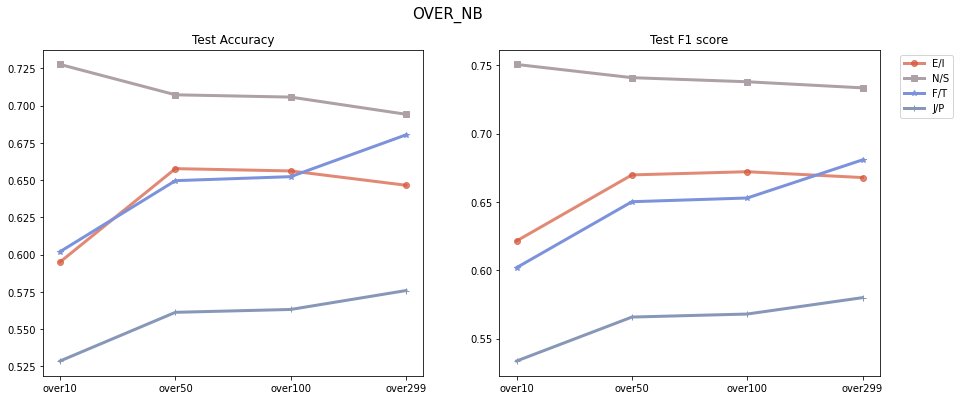

In [0]:
my_plot("over_nb")

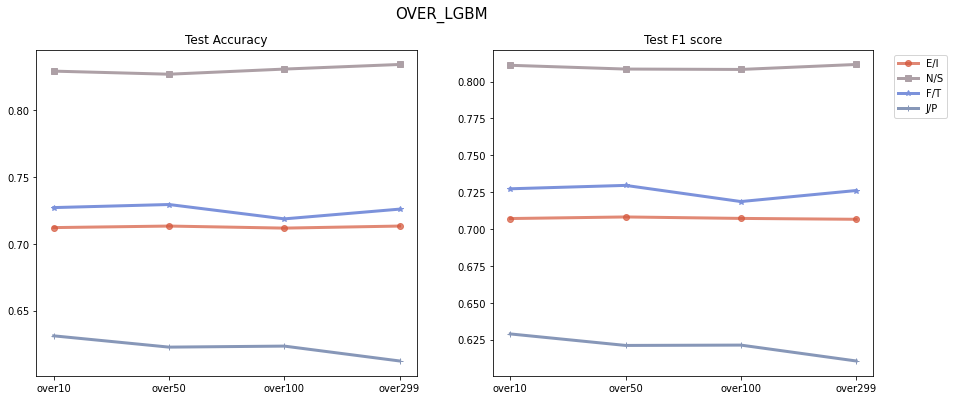

In [0]:
my_plot("over_lgbm")

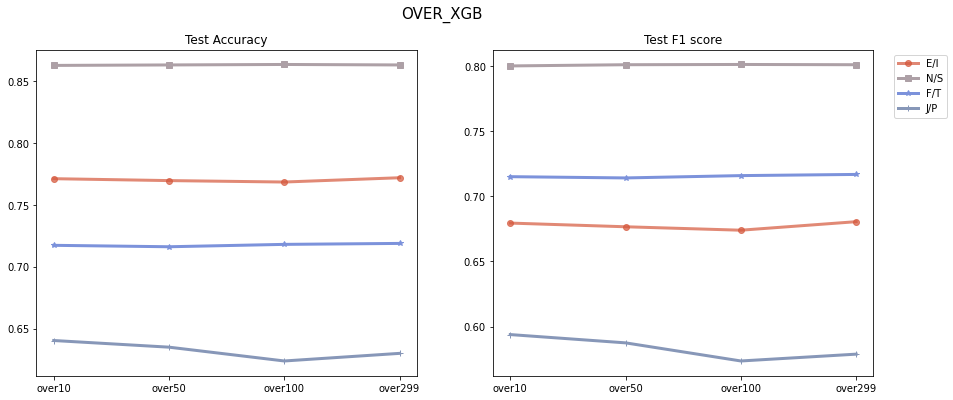

In [0]:
my_plot("over_xgb")